# Task 3: Image Super-resolution
### Submission By: [Saurabh Johri](mailto:saurabhxj@gmail.com)

### 3A Task Description
Train a deep learning-based super resolution algorithm of your choice to upscale low-resolution strong lensing images using the provided high-resolution samples as ground truths. Please implement your approach in PyTorch or Keras and discuss your strategy.

### Dataset
The dataset comprises simulated strong lensing images with no substructure at multiple resolutions: high-resolution (HR) and low-resolution (LR).

- There are 10000 image pairs (low-res, high-res) in total.
- The low resolution images are one channel and have the dimensions (75x75) pixels
- The high resolution images are also one channel and have the dimensions (150x150)




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%bash

unzip -q /content/drive/MyDrive/DeepLenseGSOC/Task3/Dataset.zip -d /content/

## Proposed Strategy

- Using the base model architecture detailed in Enhanced Deep Residual Networks for Single Image Super-Resolution by [Bee Lim et al.](https://arxiv.org/abs/1707.02921) train a residual network for upscaling the low resolution lensing images.
- Use a GPU to accelerate the training process (NVIDIA T4 in this case, through Google Colab)
- Load the images in *'.npy'* (numpy array) format using PIL (Pillow) library and create a Tensorflow Dataset for model training.
- Start without any data augmentation or any manipulations to establish a baseline and iterate with different techniques one-by-one if necessary.
- Use a training/validation split of 90% training to 10% validation.

In [ ]:
import os

import tensorflow as tf
import numpy as np
import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import roc_auc_score
from PIL import Image
import cv2
from glob import glob
from tqdm import tqdm
import gc
gc.enable()

%matplotlib inline

PATH = '/content/Dataset'
BATCH_SIZE = 16
RANDOM_SEED = 42

keras.utils.set_random_seed(RANDOM_SEED)

### Create utilities to process images

- Since the base architecture in the aforementioned paper uses 3 channel images, expand the image dimensions to 3 channels with all 3 channels being identical to each other.
- Using numpy to read the image arrays and PIL to convert them to a PIL image.
- Loading the images as a tensorflow dataset, with the aforementioned training/validation split.

In [ ]:
def load_image(file_path):
    arr = np.load(file_path)

    # channel last format
    arr = np.moveaxis(arr, 0, -1)

    # convert to three channels
    arr = np.dstack([arr, arr, arr])
    im = Image.fromarray((arr * 255).astype(np.uint8))
    return im

hr_folder = f'{PATH}/HR'
lr_folder = f'{PATH}/LR'

num_images = len(os.listdir(lr_folder))

# both low resolution and high resolution images have the same filename
# using the common file name, load the image pairs and return them
# used to map to a dataset of filenames later
def load_image_pair(image_path):
    image_path = image_path.decode('utf-8')
    lr_path, hr_path = image_path, image_path.replace('LR', 'HR')
    lr_image = load_image(lr_path)
    hr_image = load_image(hr_path)
    return lr_image, hr_image

# create a dataset of file names
dataset = tf.data.Dataset.list_files(f'{PATH}/LR/*.npy')

# map the file names to return corresponding images using the load_image_pair fn
dataset = dataset.map(lambda image_path: tf.numpy_function(load_image_pair, [image_path], [tf.uint8, tf.uint8]), num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(num_images)

# split into training and validation, and batch the datasets
train_ds = dataset.take(int(0.9 * num_images))
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = dataset.skip(int(0.9 * num_images))
val_ds = val_ds.batch(BATCH_SIZE)

### Create model
- The model makes use of residual blocks that add the original input to the output of the block to create a final output. This preserves the original information contained in the inputs.
- Rescaling the pixel values to between 0 and 1 for training.
- Using the tensorflow depth_to_space function to rearrange the image in order to match the target dimensions.

In [ ]:
# residual block
def residual_block(inputs, num_filters=64):
    x = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.Add()([inputs, x])
    return x

def make_model(num_filters, num_residual=8, factor=2):
    input_layer = layers.Input(shape=(75, 75, 3))

    # scale pixel values to between 0 and 1
    x = layers.Rescaling(scale=1.0 / 255)(input_layer)
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(x)

    # create num_residual Residual Blocks
    for _ in range(num_residual):
        x_new = residual_block(x_new, num_filters)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = layers.Conv2D(num_filters * (factor ** 2), 3, padding="same")(x)

    # upscale the image to the appropriate dimensions of the target image
    # in this case, by a factor of 2
    x = tf.nn.depth_to_space(x, block_size=factor)

    x = layers.Conv2D(3, 3, padding="same")(x)

    # rescale the images back to 0-255 range
    output_layer = layers.Rescaling(scale=255)(x)
    return keras.Model(input_layer, output_layer)

model = make_model(num_filters=32, num_residual=8)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 75, 75, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 75, 75, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 75, 75, 32)           896       ['rescaling[0][0]']           
                                                                                                  
 conv2d_1 (Conv2D)           (None, 75, 75, 32)           9248      ['conv2d[0][0]']              
                                                                                              

### Define the additional loss functions

- Creating loss functions to represent PSNR (peak signal-to-noise ratio) and SSIM (structural similartity index).
- A PSNR of above 40 dB is generally considered a good value for a reconstruction.
- A SSIM of 1 indicates a perfect reconstruction.

In [ ]:
def PSNR(high_resolution, super_resolution):
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)[0]
    return psnr_value

def SSIM(high_resolution, super_resolution):
    ssim_value = tf.image.ssim(high_resolution, super_resolution, max_val=255)[0]
    return ssim_value

### Define training parameters and fit the model

- Using the Adam optimizer with a cosine decay learning rate scheduler for smoother training.
- Using a warmup time for the cosine decay scheduler as well, this way the learning rate gradually catches up to the target before decaying.
- The learning rate will decay for ~70% of the training steps and will warm up for ~10% of the training steps.

In [ ]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)

EPOCHS = 10
total_steps = (num_images // BATCH_SIZE) * EPOCHS
decay_steps = int(total_steps * 0.7)
initial_learning_rate = 0.0
warmup_steps = int(total_steps * 0.1)
target_learning_rate = 1e-3

cosinedecay = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate, decay_steps,
        warmup_target=target_learning_rate,
        warmup_steps=warmup_steps
        )
model.compile(optimizer=keras.optimizers.Adam(learning_rate=cosinedecay), loss="mse", metrics=[PSNR, SSIM])

checkpoint_path = f'/content/drive/MyDrive/DeepLenseGSOC/Task3/task_3a.h5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_loss',
                                                 mode='min',
                                                 verbose=1)

history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, batch_size=BATCH_SIZE, callbacks=[cp_callback])

Epoch 1/10
563/563 [==============================] - ETA: 0s - loss: 79.7439 - PSNR: 37.1838 - SSIM: 0.9127
Epoch 1: val_loss improved from inf to 5.17343, saving model to /content/drive/MyDrive/DeepLenseGSOC/Task3/task_3a.h5
563/563 [==============================] - 83s 95ms/step - loss: 79.7439 - PSNR: 37.1838 - SSIM: 0.9127 - val_loss: 5.1734 - val_PSNR: 41.0751 - val_SSIM: 0.9667
Epoch 2/10
562/563 [============================>.] - ETA: 0s - loss: 4.7738 - PSNR: 41.4497 - SSIM: 0.9692
Epoch 2: val_loss improved from 5.17343 to 4.30404, saving model to /content/drive/MyDrive/DeepLenseGSOC/Task3/task_3a.h5
563/563 [==============================] - 61s 88ms/step - loss: 4.7734 - PSNR: 41.4515 - SSIM: 0.9692 - val_loss: 4.3040 - val_PSNR: 41.8565 - val_SSIM: 0.9710
Epoch 3/10
562/563 [============================>.] - ETA: 0s - loss: 4.3687 - PSNR: 41.7804 - SSIM: 0.9708
Epoch 3: val_loss improved from 4.30404 to 4.15336, saving model to /content/drive/MyDrive/DeepLenseGSOC/Task3/t

### Plot the model loss curves for observations

- Due to the loss being significantly higher for the initial epoch, a better representation can be seen when viewing the plot from the 2nd epoch onwards.

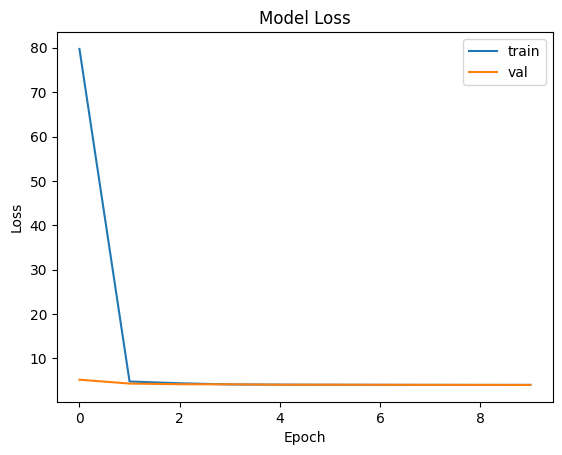

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

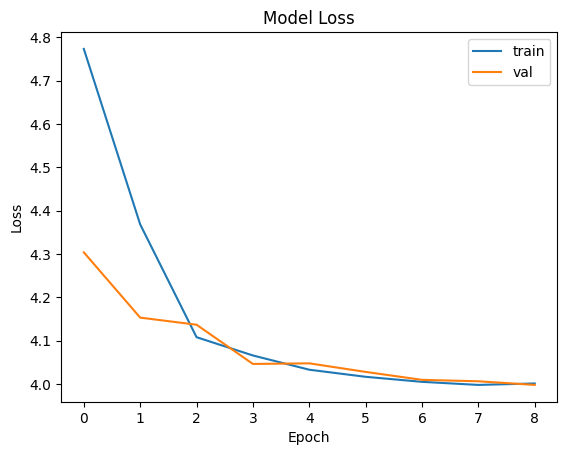

In [ ]:
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

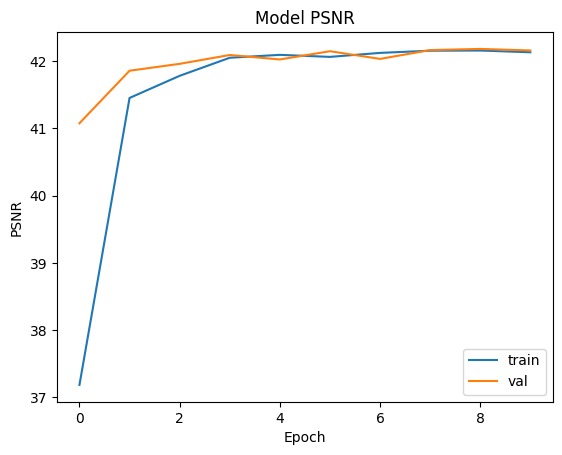

In [ ]:
plt.plot(history.history['PSNR'])
plt.plot(history.history['val_PSNR'])
plt.title('Model PSNR')
plt.ylabel('PSNR')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

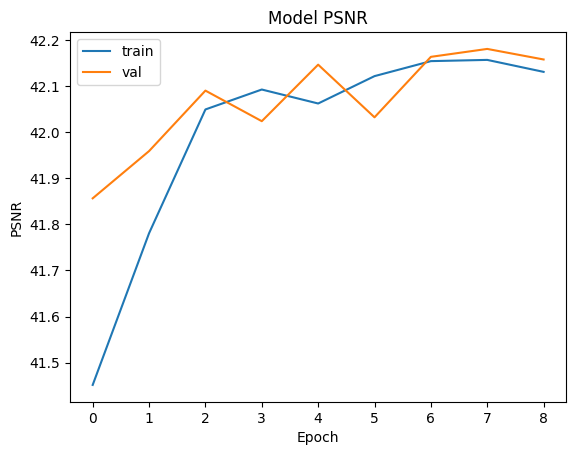

In [ ]:
plt.plot(history.history['PSNR'][1:])
plt.plot(history.history['val_PSNR'][1:])
plt.title('Model PSNR')
plt.ylabel('PSNR')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

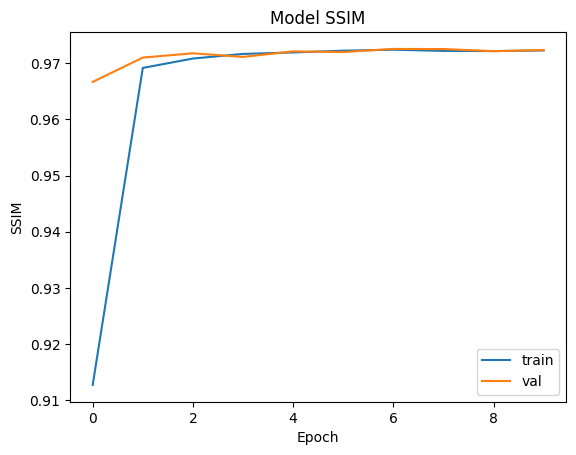

In [ ]:
plt.plot(history.history['SSIM'])
plt.plot(history.history['val_SSIM'])
plt.title('Model SSIM')
plt.ylabel('SSIM')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

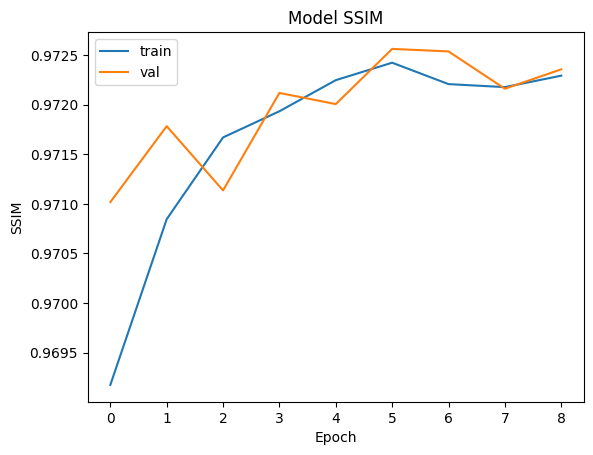

In [ ]:
plt.plot(history.history['SSIM'][1:])
plt.plot(history.history['val_SSIM'][1:])
plt.title('Model SSIM')
plt.ylabel('SSIM')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

### Sample and plot images

- Sampling some images from the validation set and plotting their reconstructions/superresolutions alongside the low-res and high-res versions for qualitative observation.

In [ ]:
def plot_results(lowres, highres, preds):
    plt.figure(figsize=(14, 7))
    plt.subplot(131), plt.imshow(lowres), plt.title("Low resolution")
    plt.subplot(132), plt.imshow(highres), plt.title("High resolution")
    plt.subplot(133), plt.imshow(preds), plt.title("Prediction")
    plt.show()

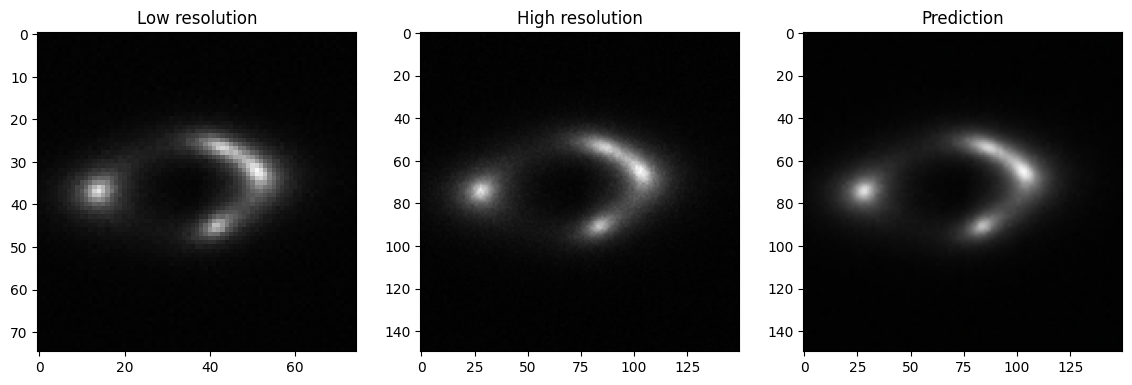

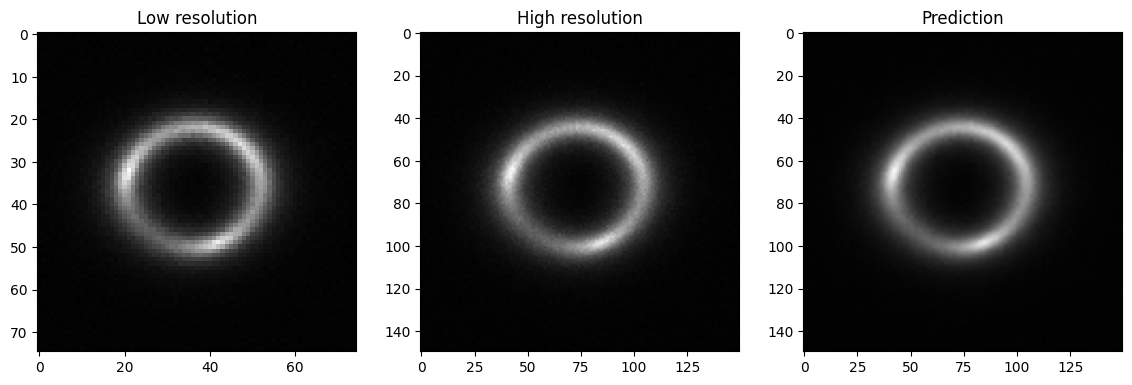

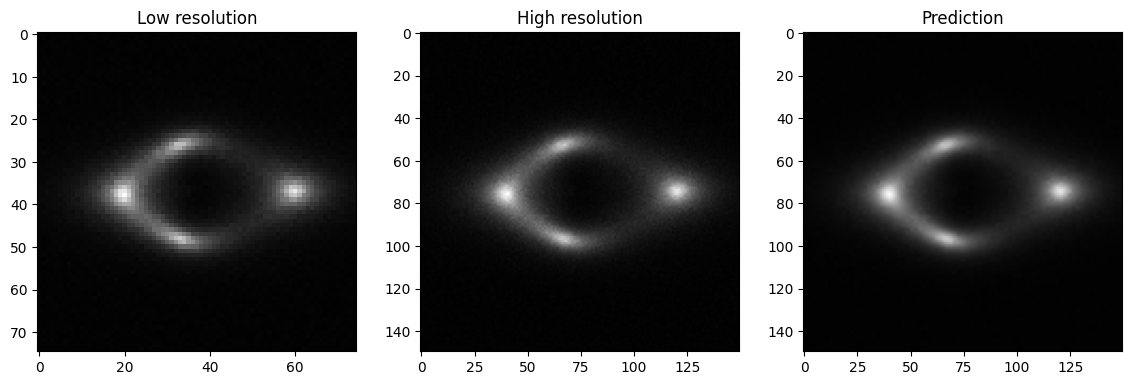

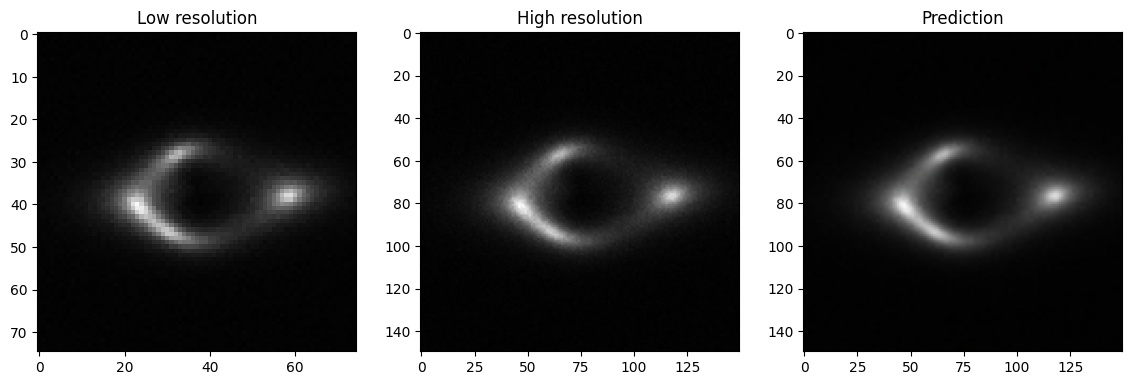

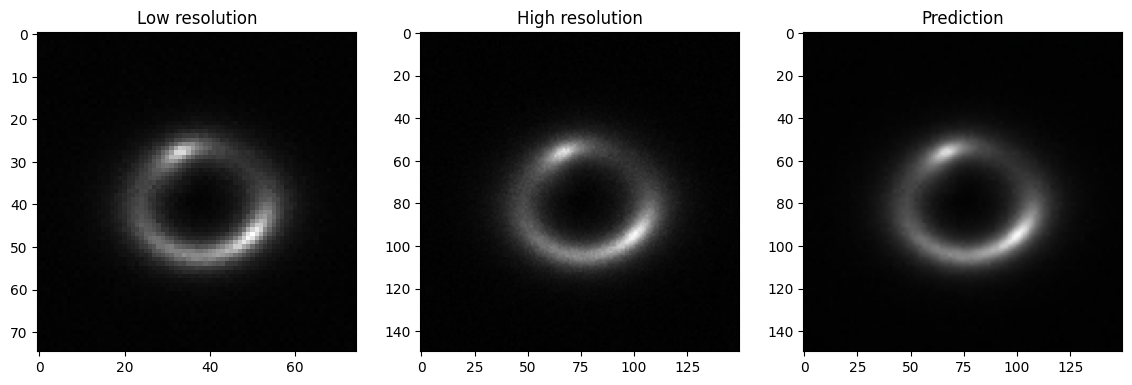

In [ ]:
for lowres, highres in val_ds.take(1):
    preds = model.predict_step(lowres)
    for i in range(5):
      plot_results(lowres[i], highres[i], preds[i].numpy().astype(np.uint8))

### Saving the entire model as an alternative option

In [ ]:
model.save('/content/drive/MyDrive/DeepLenseGSOC/Task3/task_3a_model.keras')

### Observations

- The super-resolution model converges on a MSE (mean-squared error) of around 4.0
- The PSNR (peak signal-to-noise ratio) achieved is around 42 dB which is a good value for image reconstruction.
- The SSIM (structural similarity index) achieved is around 0.97.
- These observations are also evident in the visual inspection of the high-res images (ground truth) to the superresolution predictions of the model.
- The predictions are clearly a step above the low resolution inputs and very similar to the high resolution images albeit lacking some fidelity (slight blurriness).
- The model is able to generalize well on this dataset of simulated lensing images.
- The model training history also does not indicate any overfitting as validation loss decreased in tandem with the training loss.